# データセットの取得

「ポムポムプリン」と「ぐでたま」の分類を行った。データセットの取得は以下のコードを使って行った。

（参考：https://note.com/mscreate1/n/nfb49e98b5447 ）

コードを以下に示す。



```
!pip install keras==2.2.5
!pip install tensorflow==1.14.0
!pip install h5py==2.10.0
!pip install icrawler #クローラーインストール 

from icrawler.builtin import BaiduImageCrawler, BingImageCrawler, GoogleImageCrawler

#Google  Driveマウント
from google.colab import drive
drive.mount('/content/drive')

#キーワードとディレクトリー 
target_keyword = "\u30DD\u30E0\u30DD\u30E0\u30D7\u30EA\u30F3\u3000\u30A4\u30E9\u30B9\u30C8" #@param {type:"string"}
target_directory = 'pomu2' #@param {type:"string"}
photo_num = 250 #@param {type:"integer"}

bing_crawler = BingImageCrawler(downloader_threads=4,
                                storage={'root_dir': '/content/drive/MyDrive/'+target_directory})
bing_crawler.crawl(keyword=target_keyword, filters=None, offset=0, max_num=photo_num)

# Googleの画像を取得
google_crawler = GoogleImageCrawler(
    feeder_threads=1,
    parser_threads=1,
    downloader_threads=4,
    storage={'root_dir': '/content/drive/Mydrive/'+target_directory})
filters = dict(
    size='large',
    color='orange',
    date=((2020, 1, 1), (2022, 11, 30)))
google_crawler.crawl(keyword=target_keyword, filters=filters, offset=0, max_num=photo_num,
                     min_size=(200,200), max_size=None, file_idx_offset=0)

```

取得した画像データは以下の通り（ポムポムプリン250枚、ぐでたま274枚）

https://drive.google.com/drive/folders/1IrJbhjqXrgqWPueHwYGQqg9vv0vSVTJN?usp=share_link



# 学習の実行

In [ ]:
cuda = "cuda:0"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
device = torch.device(cuda if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
image_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/data")

In [ ]:
batch_size = 64
num_epochs = 10

In [ ]:
data_transforms = {
  'train': transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'val': transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
}

image_datasets = {x: datasets.ImageFolder("/content/drive/MyDrive/data", data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                  batch_size=batch_size, shuffle=True, num_workers=4)
                  for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x])
                  for x in ['train', 'val']}
class_names = image_datasets['train'].classes
acc_list = {x: [] for x in ['train', 'val']}


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([64, 3, 224, 224]) torch.Size([64])


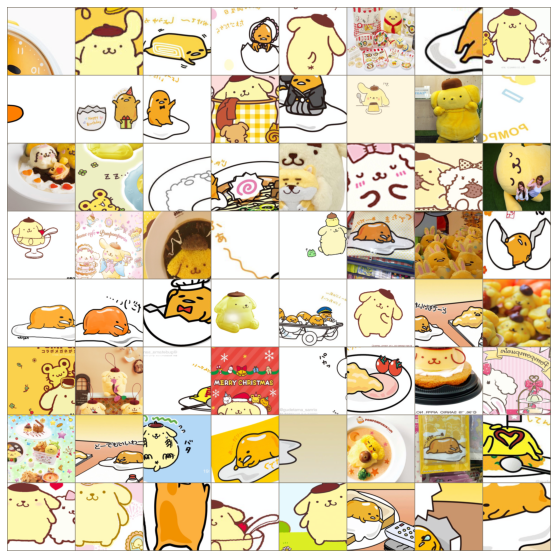

In [ ]:
def imshow(images, title=None, size=10):
  images = images.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  images = std * images + mean
  images = np.clip(images, 0, 1)
  plt.figure(figsize=(size,size))
  plt.imshow(images)
  plt.axis("off")
#  if title is not None:
#    plt.title(title)
images, classes = next(iter(dataloaders['train']))
print(images.size(), classes.size())
images = torchvision.utils.make_grid(images)
imshow(images, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs):
  since = time.time()
  epoch_loss = 0.0
  epoch_acc = 0.0
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))  
    # 各エポックで訓練+バリデーションを実行
    for phase in ['train', 'val']:
      if phase == 'train':
        scheduler.step()
        model.train()
      else:
        model.eval()
      running_loss = 0.0
      running_corrects = 0
      for data in dataloaders[phase]:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # 順伝播
        if phase == 'train':
          outputs = model(inputs)
        else:
          with torch.no_grad():
            outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1) #_は無視、データを捨てる
        loss = criterion(outputs, labels)
        if phase == 'train':
          loss.backward()
          optimizer.step()
        running_loss += loss.data.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      epoch_loss = running_loss/dataset_sizes[phase]
      epoch_acc = running_corrects.item()/dataset_sizes[phase]
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      # よい精度のモデルを自動的に保存する、よくあるテクニック
      acc_list[phase].append(epoch_acc)
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed / 60, time_elapsed % 60))
  print('Best val acc: {:.4f}'.format(best_acc))
  model.load_state_dict(best_model_wts) #もっともよいモデルを読み直す
  return model

In [ ]:
model_ft = models.resnet18(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
num_features = model_ft.fc.in_features
# fc層を置き換える
model_ft.fc = nn.Linear(num_features, 2)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7エポックごとに学習率を0.1倍する
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)
torch.save(model_ft.state_dict(), 'model_ft.pkl')
acc_list_ft = acc_list['val'].copy()
acc_list['val'] = []

Epoch 0/9


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.7222 Acc: 0.5985
val Loss: 0.4970 Acc: 0.7820
Epoch 1/9
train Loss: 0.4035 Acc: 0.8260
val Loss: 0.2838 Acc: 0.8948
Epoch 2/9
train Loss: 0.2167 Acc: 0.9312
val Loss: 0.1540 Acc: 0.9579
Epoch 3/9
train Loss: 0.1600 Acc: 0.9503
val Loss: 0.1161 Acc: 0.9713
Epoch 4/9
train Loss: 0.1415 Acc: 0.9522
val Loss: 0.0956 Acc: 0.9790
Epoch 5/9
train Loss: 0.1138 Acc: 0.9790
val Loss: 0.0889 Acc: 0.9790
Epoch 6/9
train Loss: 0.1206 Acc: 0.9656
val Loss: 0.0829 Acc: 0.9866
Epoch 7/9
train Loss: 0.0993 Acc: 0.9809
val Loss: 0.0782 Acc: 0.9885
Epoch 8/9
train Loss: 0.1367 Acc: 0.9541
val Loss: 0.0764 Acc: 0.9828
Epoch 9/9
train Loss: 0.1034 Acc: 0.9637
val Loss: 0.0763 Acc: 0.9885
Training complete in 3m 48s
Best val acc: 0.9885


In [ ]:
# 訓練済みResNet18をロード
model_conv = torchvision.models.resnet18(pretrained=True)
# 全パラメータを固定
for param in model_conv.parameters():
  param.requires_grad = False
# 最後のfc層を置き換える(requires_grad=Trueでありパラメータ更新の対象)
num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
# Optimizerの第1引数には更新対象のfc層のパラメータのみ指定
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                       exp_lr_scheduler, num_epochs=num_epochs)
acc_list_tr = acc_list['val'].copy()

Epoch 0/9
train Loss: 0.6889 Acc: 0.5927
val Loss: 0.5710 Acc: 0.6654
Epoch 1/9
train Loss: 0.5079 Acc: 0.7610
val Loss: 0.3598 Acc: 0.9025
Epoch 2/9
train Loss: 0.4099 Acc: 0.8356
val Loss: 0.2824 Acc: 0.9044
Epoch 3/9
train Loss: 0.2819 Acc: 0.9025
val Loss: 0.2358 Acc: 0.9293
Epoch 4/9
train Loss: 0.2359 Acc: 0.9216
val Loss: 0.2147 Acc: 0.9312
Epoch 5/9
train Loss: 0.2270 Acc: 0.9254
val Loss: 0.1956 Acc: 0.9446
Epoch 6/9
train Loss: 0.2237 Acc: 0.9159
val Loss: 0.1942 Acc: 0.9350
Epoch 7/9
train Loss: 0.2112 Acc: 0.9254
val Loss: 0.1912 Acc: 0.9446
Epoch 8/9
train Loss: 0.1988 Acc: 0.9312
val Loss: 0.1911 Acc: 0.9484
Epoch 9/9
train Loss: 0.2100 Acc: 0.9331
val Loss: 0.1885 Acc: 0.9465
Training complete in 3m 36s
Best val acc: 0.9484


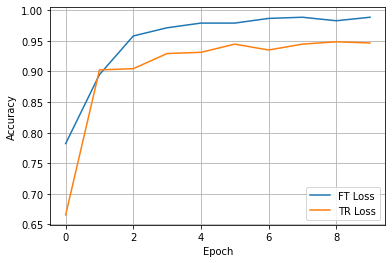

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(num_epochs), acc_list_ft, label='FT Loss')
plt.plot(range(num_epochs), acc_list_tr, label='TR Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

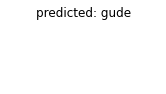

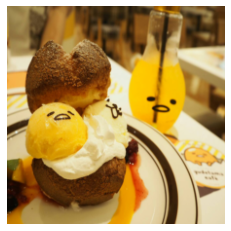

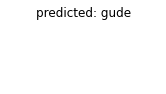

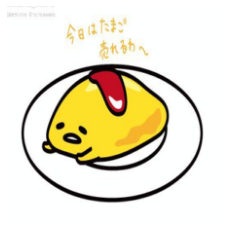

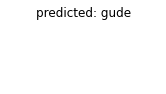

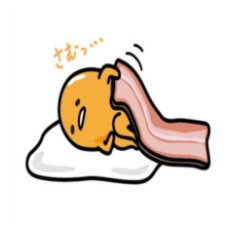

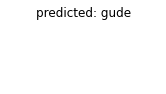

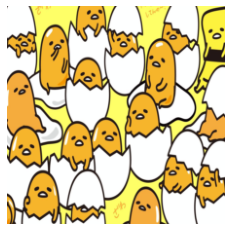

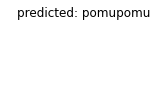

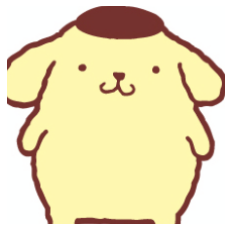

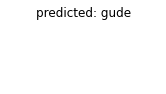

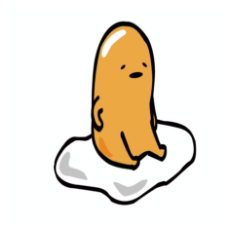

In [ ]:
model_ft.load_state_dict(torch.load('model_ft.pkl', map_location=lambda storage, loc: storage))
def visualize_model(model, num_images=6):
  images_so_far = 0
  fig = plt.figure()
  model.eval()
  for i, data in enumerate(dataloaders['val']):
    inputs, labels = data
    inputs = inputs.cuda().to(device)
    inputs.requires_grad = False
    labels = labels.cuda().to(device)
    labels.requires_grad = False
    with torch.no_grad():
      outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)
    for j in range(inputs.size()[0]):
      images_so_far += 1
      plt.subplot(num_images // 2, 2, images_so_far)
      plt.axis('off')
      plt.title('predicted: {}'.format(class_names[preds[j]]))
      imshow(inputs.cpu().data[j], size=4)
      plt.show()
      if images_so_far == num_images:
        return
visualize_model(model_ft)